In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import sys

num_frames = 166
video_imgs = []
readdir = 'D:/44754/Documents/robotics/Perception/RoboticsPerceptionWeek3Code/data/apriltagims/image{:03d}.jpg'
for i in range(num_frames):
    tmp = cv2.imread(readdir.format(i+1))
    video_imgs.append(tmp)
video_imgs = np.array(video_imgs)
print(video_imgs.shape)

(166, 480, 640, 3)


In [23]:
initial_points = 100 * np.array([
   [1.981631469726562,3.165294189453125],
   [3.786268920898438,3.424402770996094],
   [4.036800842285157,1.686005859375000],
   [2.333528289794922,1.491907043457031] ]);
K = 100*np.array([[7.661088867187500,0,3.139585628047498],
                 [0,7.699354248046875,2.503607131410900],
                 [0,0,0.010000000000000]])
pr = np.array([[1,0,0],[0,1,0]])
tag_width = 0.13
tag_height = 0.13
cube_depth = 0.13
print(initial_points.shape)
print(K.shape)

(4, 2)
(3, 3)


In [17]:
class KLTtrack():
    def __init__(self,imglist,trackpts):
        self.vid = imglist
        self.pts = trackpts
        # Parameters for lucas kanade optical flow
        self.lk_params = dict(winSize  = (31,31),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT, 5, 0.03))

    def pointTracker(self):
        # Create some random colors
        color = np.random.randint(0,255,(self.pts.shape[0],3))
        # Take first frame and find corners in it
        old_frame = self.vid[0,:,:,:]
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        p0 = np.floor(self.pts).reshape(-1,1,2).astype(np.float32)
        
        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)
        corners = []
        corners.append(self.pts)

        for i in range(1,num_frames):
            frame = video_imgs[i,:,:,:]
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # calculate optical flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **self.lk_params)
            # Select good points
            good_new = p1[st==1]
            good_old = p0[st==1]
            # draw the tracks
            for i,(new,old) in enumerate(zip(good_new, good_old)):
                a,b = new.ravel()
                c,d = old.ravel()
                mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
            img = cv2.add(frame,mask)

            k = cv2.waitKey(5) & 0xff
            if k == 27:
                break
            # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            corners.append(good_new)
            p0 = good_new.reshape(-1,1,2)
            
        return np.array(corners)

In [18]:
## generate klt images
demo = KLTtrack(video_imgs,initial_points)
corners = demo.pointTracker()

In [19]:
np.floor(corners).shape

(166, 4, 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


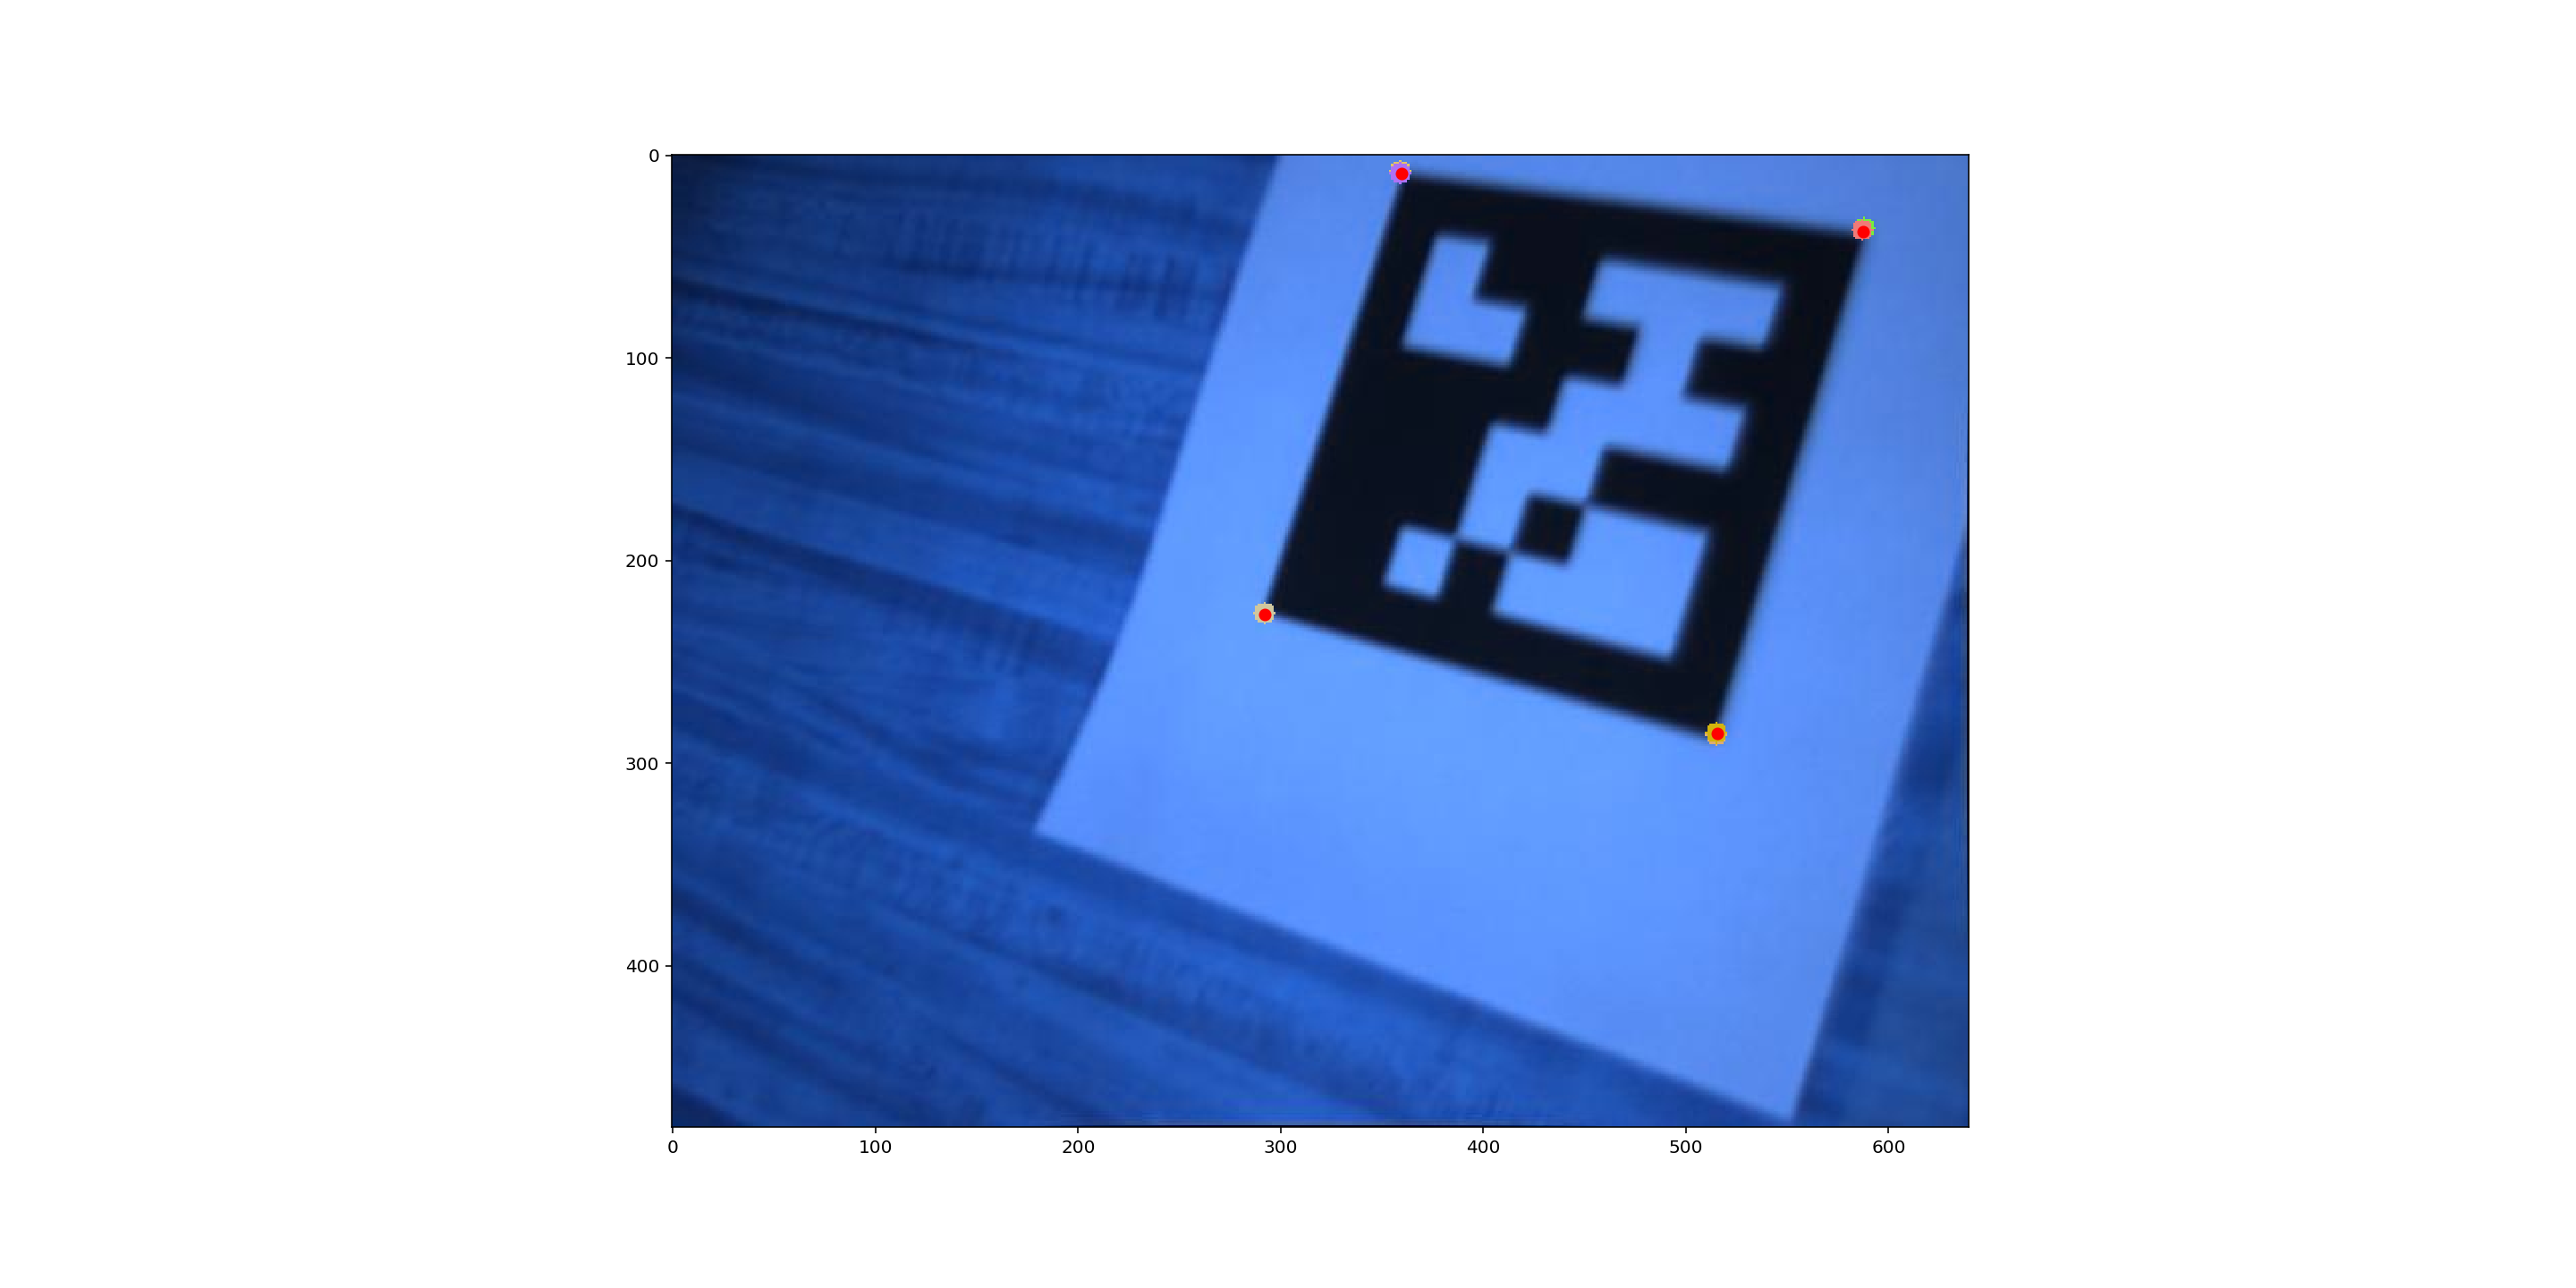

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.ion()
fig.show()
fig.canvas.draw()

for i in range(num_frames):
    ax.clear()
    ax.imshow(video_imgs[i,:,:,:])
    ax.plot(corners[i,:,0],corners[i,:,1],'ro')
    fig.canvas.draw()